In [ ]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 54 kB/s 


In [ ]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from hyperopt import fmin, hp, tpe

In [ ]:
train_df = pd.read_csv("Train.csv")
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124117 entries, 0 to 124116
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                124117 non-null  object 
 1   Toxin_UniprotID   124117 non-null  object 
 2   Position_start    124117 non-null  int64  
 3   Position_end      124117 non-null  int64  
 4   Antivenom         124117 non-null  object 
 5   Toxin_K_mer       124117 non-null  object 
 6   Signal            124117 non-null  float64
 7   Genus             124117 non-null  object 
 8   Species           124117 non-null  object 
 9   ProteinFam        124117 non-null  object 
 10  ProteinSubFam     76085 non-null   object 
 11  ProteinSubSubFam  61957 non-null   object 
dtypes: float64(1), int64(2), object(9)
memory usage: 11.4+ MB
None


In [ ]:
train_df.tail()

,ID,Toxin_UniprotID,Position_start,Position_end,Antivenom,Toxin_K_mer,Signal,Genus,Species,ProteinFam,ProteinSubFam,ProteinSubSubFam
124112,M5BGY5_VINS_Central_Africa_92,M5BGY5,92,107,VINS_Central_Africa,DMNDYCTGTTPDCPRN,1.06,Atheris,Atheris_chlorechis,Disintegrin,Dimeric_disintegrin_subfamily,NaN
124113,M5BGY5_VINS_Central_Africa_93,M5BGY5,93,108,VINS_Central_Africa,MNDYCTGTTPDCPRNP,0.80,Atheris,Atheris_chlorechis,Disintegrin,Dimeric_disintegrin_subfamily,NaN
124114,M5BGY5_VINS_Central_Africa_94,M5BGY5,94,109,VINS_Central_Africa,NDYCTGTTPDCPRNPY,0.43,Atheris,Atheris_chlorechis,Disintegrin,Dimeric_disintegrin_subfamily,NaN
124115,M5BGY5_VINS_Central_Africa_95,M5BGY5,95,110,VINS_Central_Africa,DYCTGTTPDCPRNPYK,1.46,Atheris,Atheris_chlorechis,Disintegrin,Dimeric_disintegrin_subfamily,NaN
124116,M5BGY5_VINS_Central_Africa_96,M5BGY5,96,111,VINS_Central_Africa,YCTGTTPDCPRNPYKD,1.47,Atheris,Atheris_chlorechis,Disintegrin,Dimeric_disintegrin_subfamily,NaN


In [ ]:
X = train_df.drop('Signal', axis = 1)
X_train, X_val, y_train, y_val = train_test_split(X, train_df.Signal, test_size = 0.9, random_state = 42)

In [ ]:
X_train.head()

,ID,Toxin_UniprotID,Position_start,Position_end,Antivenom,Toxin_K_mer,Genus,Species,ProteinFam,ProteinSubFam,ProteinSubSubFam
14274,Q7T247_Premium_92,Q7T247,92,107,Premium,TDYWRDCNWEWSDGAQ,Echis,Echis_carinatus,Snaclec,NaN,NaN
7848,B5U6Y3_ICP_54,B5U6Y3,54,69,ICP,LIHEEWVLSAAHCDME,Echis,Echis_ocellatus,Peptidase_S1,Snake_venom_subfamily,NaN
48380,P25517_VINS_Africa_27,P25517,27,42,VINS_Africa,RLAPKVPVKRGCIDVC,Naja,Naja_mossambica,Snake_three_finger_toxin,Short_chain_subfamily,Type_IA_cytotoxin_sub_subfamily
107850,P01424_VINS_Central_Africa_40,P01424,40,55,VINS_Central_Africa,CGCPSVKKGVKINCCT,Naja,Naja_melanoleuca,Snake_three_finger_toxin,Short_chain_subfamily,Type_I_alpha_neurotoxin_sub_subfamily
25025,Q2UXR0_Sanofi_Pasteur_582,Q2UXR0,582,597,Sanofi_Pasteur,PRDEDKGMVDPGTKCE,Echis,Echis_ocellatus,Venom_metalloproteinase_M12B,P_III_subfamily,P_IIIc_sub_subfamily


In [ ]:
X_train.drop('Toxin_UniprotID', axis = 1, inplace = True)
X_val.drop('Toxin_UniprotID', axis = 1, inplace = True)
X_train.set_index('ID', inplace=True)
X_val.set_index('ID', inplace=True)

In [ ]:
imputer = SimpleImputer(strategy = "most_frequent")

impfit = imputer.fit(X_train)
train = pd.DataFrame(impfit.transform(X_train), columns = X_train.columns)
val_df = pd.DataFrame(impfit.transform(X_val), columns = X_train.columns)

In [ ]:
train.head()

,Position_start,Position_end,Antivenom,Toxin_K_mer,Genus,Species,ProteinFam,ProteinSubFam,ProteinSubSubFam
0,92,107,Premium,TDYWRDCNWEWSDGAQ,Echis,Echis_carinatus,Snaclec,Short_chain_subfamily,D49_sub_subfamily
1,54,69,ICP,LIHEEWVLSAAHCDME,Echis,Echis_ocellatus,Peptidase_S1,Snake_venom_subfamily,D49_sub_subfamily
2,27,42,VINS_Africa,RLAPKVPVKRGCIDVC,Naja,Naja_mossambica,Snake_three_finger_toxin,Short_chain_subfamily,Type_IA_cytotoxin_sub_subfamily
3,40,55,VINS_Central_Africa,CGCPSVKKGVKINCCT,Naja,Naja_melanoleuca,Snake_three_finger_toxin,Short_chain_subfamily,Type_I_alpha_neurotoxin_sub_subfamily
4,582,597,Sanofi_Pasteur,PRDEDKGMVDPGTKCE,Echis,Echis_ocellatus,Venom_metalloproteinase_M12B,P_III_subfamily,P_IIIc_sub_subfamily


In [ ]:
cat_features = train.columns[np.where(train.dtypes != float)[0]].values.tolist()
cat_features

['Position_start',
 'Position_end',
 'Antivenom',
 'Toxin_K_mer',
 'Genus',
 'Species',
 'ProteinFam',
 'ProteinSubFam',
 'ProteinSubSubFam']

In [ ]:
catmodel = CatBoostRegressor(iterations=1000,
                           task_type="GPU",
                           devices='0',
                           loss_function='RMSE')

catmodel.fit(train, y_train, eval_set=(val_df, y_val), cat_features=cat_features)

Learning rate set to 0.081516
0:	learn: 1.0992981	test: 1.1030773	best: 1.1030773 (0)	total: 76.5ms	remaining: 1m 16s
1:	learn: 1.0825307	test: 1.0825353	best: 1.0825353 (1)	total: 139ms	remaining: 1m 9s
2:	learn: 1.0676184	test: 1.0649601	best: 1.0649601 (2)	total: 195ms	remaining: 1m 4s
3:	learn: 1.0539715	test: 1.0482236	best: 1.0482236 (3)	total: 309ms	remaining: 1m 17s
4:	learn: 1.0410092	test: 1.0325374	best: 1.0325374 (4)	total: 419ms	remaining: 1m 23s
5:	learn: 1.0302416	test: 1.0189211	best: 1.0189211 (5)	total: 531ms	remaining: 1m 27s
6:	learn: 1.0203291	test: 1.0069294	best: 1.0069294 (6)	total: 617ms	remaining: 1m 27s
7:	learn: 1.0124352	test: 0.9965334	best: 0.9965334 (7)	total: 694ms	remaining: 1m 26s
8:	learn: 1.0055650	test: 0.9875218	best: 0.9875218 (8)	total: 771ms	remaining: 1m 24s
9:	learn: 0.9985053	test: 0.9777614	best: 0.9777614 (9)	total: 860ms	remaining: 1m 25s
10:	learn: 0.9919939	test: 0.9696305	best: 0.9696305 (10)	total: 958ms	remaining: 1m 26s
11:	learn: 0

In [ ]:
test_df = pd.read_csv("Test.csv")

In [ ]:
test_df.drop('Toxin_UniprotID', axis = 1, inplace = True)
test_df.set_index('ID', inplace = True)
processed_test = pd.DataFrame(impfit.transform(test_df), columns = X_train.columns)

In [ ]:
train.head()

,Position_start,Position_end,Antivenom,Toxin_K_mer,Genus,Species,ProteinFam,ProteinSubFam,ProteinSubSubFam
0,92,107,Premium,TDYWRDCNWEWSDGAQ,Echis,Echis_carinatus,Snaclec,Short_chain_subfamily,D49_sub_subfamily
1,54,69,ICP,LIHEEWVLSAAHCDME,Echis,Echis_ocellatus,Peptidase_S1,Snake_venom_subfamily,D49_sub_subfamily
2,27,42,VINS_Africa,RLAPKVPVKRGCIDVC,Naja,Naja_mossambica,Snake_three_finger_toxin,Short_chain_subfamily,Type_IA_cytotoxin_sub_subfamily
3,40,55,VINS_Central_Africa,CGCPSVKKGVKINCCT,Naja,Naja_melanoleuca,Snake_three_finger_toxin,Short_chain_subfamily,Type_I_alpha_neurotoxin_sub_subfamily
4,582,597,Sanofi_Pasteur,PRDEDKGMVDPGTKCE,Echis,Echis_ocellatus,Venom_metalloproteinase_M12B,P_III_subfamily,P_IIIc_sub_subfamily


In [ ]:
test_pred = catmodel.predict(processed_test)

In [ ]:
test_df.reset_index(inplace = True)

In [ ]:
sample_submission=test_df[["ID"]]
sample_submission["Signal"] = test_pred.reshape((-1))
sample_submission.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Signal
0,P19003_Bioclone_1,-0.673186
1,P19003_Bioclone_2,-0.712688
2,P19003_Bioclone_3,-0.643595
3,P19003_Bioclone_4,-0.711190
4,P19003_Bioclone_5,-0.785578


In [ ]:
sample_submission.to_csv("./sample_submission.csv",index=False)

In [ ]:
train.columns

Index(['Position_start', 'Position_end', 'Antivenom', 'Toxin_K_mer', 'Genus',
       'Species', 'ProteinFam', 'ProteinSubFam', 'ProteinSubSubFam'],
      dtype='object')

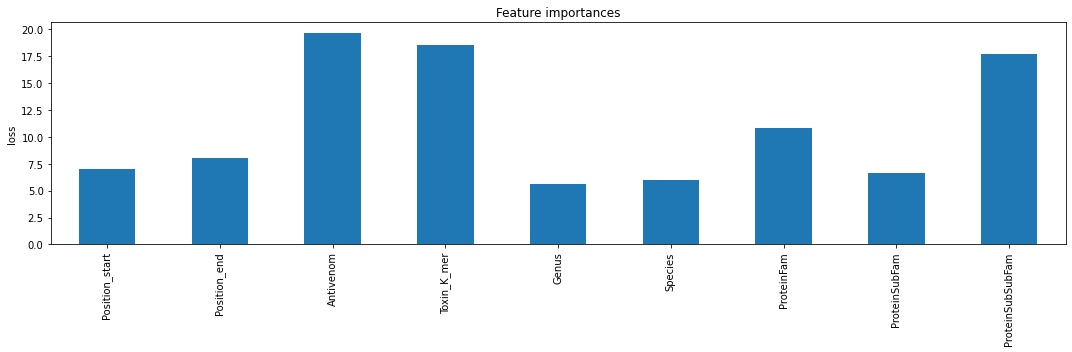

In [ ]:
import matplotlib.pyplot as plt

importances = pd.Series(catmodel.feature_importances_, index=train.columns)

fig, ax = plt.subplots(figsize = (15,5))
importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("loss")
fig.tight_layout()

# 2

In [ ]:
X_train.drop(['ProteinSubFam',	'ProteinSubSubFam'], axis = 1, inplace = True)
X_val.drop(['ProteinSubFam',	'ProteinSubSubFam'], axis = 1, inplace = True)

In [ ]:
cat_features = X_train.columns[np.where(X_train.dtypes != float)[0]].values.tolist()

In [ ]:
catmodel = CatBoostRegressor(iterations=1000,
                           task_type="GPU",
                           devices='0',
                           loss_function='RMSE')

catmodel.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=cat_features)

Learning rate set to 0.081516
0:	learn: 1.1018105	test: 1.1046471	best: 1.1046471 (0)	total: 41.1ms	remaining: 41s
1:	learn: 1.0865492	test: 1.0855389	best: 1.0855389 (1)	total: 77.2ms	remaining: 38.5s
2:	learn: 1.0727000	test: 1.0688665	best: 1.0688665 (2)	total: 115ms	remaining: 38.2s
3:	learn: 1.0609843	test: 1.0534816	best: 1.0534816 (3)	total: 152ms	remaining: 37.9s
4:	learn: 1.0500850	test: 1.0394023	best: 1.0394023 (4)	total: 188ms	remaining: 37.5s
5:	learn: 1.0405821	test: 1.0277632	best: 1.0277632 (5)	total: 224ms	remaining: 37.1s
6:	learn: 1.0304753	test: 1.0138009	best: 1.0138009 (6)	total: 254ms	remaining: 36.1s
7:	learn: 1.0230127	test: 1.0030267	best: 1.0030267 (7)	total: 285ms	remaining: 35.3s
8:	learn: 1.0164435	test: 0.9947995	best: 0.9947995 (8)	total: 321ms	remaining: 35.3s
9:	learn: 1.0101354	test: 0.9859572	best: 0.9859572 (9)	total: 347ms	remaining: 34.4s
10:	learn: 1.0046349	test: 0.9782993	best: 0.9782993 (10)	total: 373ms	remaining: 33.5s
11:	learn: 1.0005399	t

In [ ]:
X_train.head()

,Position_start,Position_end,Antivenom,Toxin_K_mer,Genus,Species,ProteinFam
ID,,,,,,,
Q7T247_Premium_92,92,107,Premium,TDYWRDCNWEWSDGAQ,Echis,Echis_carinatus,Snaclec
B5U6Y3_ICP_54,54,69,ICP,LIHEEWVLSAAHCDME,Echis,Echis_ocellatus,Peptidase_S1
P25517_VINS_Africa_27,27,42,VINS_Africa,RLAPKVPVKRGCIDVC,Naja,Naja_mossambica,Snake_three_finger_toxin
P01424_VINS_Central_Africa_40,40,55,VINS_Central_Africa,CGCPSVKKGVKINCCT,Naja,Naja_melanoleuca,Snake_three_finger_toxin
Q2UXR0_Sanofi_Pasteur_582,582,597,Sanofi_Pasteur,PRDEDKGMVDPGTKCE,Echis,Echis_ocellatus,Venom_metalloproteinase_M12B


In [ ]:
X_train1 = X_train[['Antivenom', 'Toxin_K_mer', 'ProteinFam' ]]

In [ ]:
X_train1['Position'] =  X_train['Position_end']/X_train['Position_start']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
X_train1.head()

,Antivenom,Toxin_K_mer,ProteinFam,Position
ID,,,,
Q7T247_Premium_92,Premium,TDYWRDCNWEWSDGAQ,Snaclec,1.163043
B5U6Y3_ICP_54,ICP,LIHEEWVLSAAHCDME,Peptidase_S1,1.277778
P25517_VINS_Africa_27,VINS_Africa,RLAPKVPVKRGCIDVC,Snake_three_finger_toxin,1.555556
P01424_VINS_Central_Africa_40,VINS_Central_Africa,CGCPSVKKGVKINCCT,Snake_three_finger_toxin,1.375000
Q2UXR0_Sanofi_Pasteur_582,Sanofi_Pasteur,PRDEDKGMVDPGTKCE,Venom_metalloproteinase_M12B,1.025773


In [ ]:
X_val1 =  X_val[['Antivenom', 'Toxin_K_mer', 'ProteinFam' ]]
X_val1['Position'] =  X_val['Position_end']/X_val['Position_start']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
cat_features = ['Antivenom', 'Toxin_K_mer', 'ProteinFam' ]
catmodel = CatBoostRegressor(iterations=1000,
                           task_type="GPU",
                           devices='0',
                           loss_function='RMSE')

catmodel.fit(X_train1, y_train, eval_set=(X_val1, y_val), cat_features=cat_features)

Learning rate set to 0.081516
0:	learn: 1.1016809	test: 1.1047980	best: 1.1047980 (0)	total: 68.7ms	remaining: 1m 8s
1:	learn: 1.0845601	test: 1.0821080	best: 1.0821080 (1)	total: 138ms	remaining: 1m 9s
2:	learn: 1.0696878	test: 1.0618048	best: 1.0618048 (2)	total: 175ms	remaining: 58.1s
3:	learn: 1.0579928	test: 1.0470102	best: 1.0470102 (3)	total: 207ms	remaining: 51.5s
4:	learn: 1.0475604	test: 1.0337495	best: 1.0337495 (4)	total: 242ms	remaining: 48.1s
5:	learn: 1.0375599	test: 1.0192453	best: 1.0192453 (5)	total: 281ms	remaining: 46.5s
6:	learn: 1.0289018	test: 1.0071051	best: 1.0071051 (6)	total: 312ms	remaining: 44.3s
7:	learn: 1.0222142	test: 0.9984400	best: 0.9984400 (7)	total: 338ms	remaining: 41.9s
8:	learn: 1.0156798	test: 0.9891085	best: 0.9891085 (8)	total: 364ms	remaining: 40.1s
9:	learn: 1.0095837	test: 0.9804782	best: 0.9804782 (9)	total: 389ms	remaining: 38.6s
10:	learn: 1.0044508	test: 0.9731156	best: 0.9731156 (10)	total: 415ms	remaining: 37.3s
11:	learn: 0.9996186	

In [ ]:
D_train = Pool(X_train1, y_train, cat_features=cat_features)
D_test = Pool(X_val1, y_val, cat_features=cat_features)

In [ ]:
import time
start = time.time()
space_lr = {'depth': hp.quniform('max_depth', 5, 10, 1),
            'iterations' : hp.quniform('iterations', 500, 1000, 1),
            'learning_rate': hp.uniform('learning_rate',0.001, 1),
            }
rmse_score = make_scorer(mean_squared_error, greater_is_better = False) 
def catb_model(params):
    params = {'depth': int(params['depth']),
              'learning_rate': params['learning_rate'],
              'iterations' : int(params['iterations']),
              'cat_features' : cat_features,
              'task_type' : "GPU",
              'devices' : '0',
              'loss_function' : 'RMSE'
              }
    catb = CatBoostRegressor(random_state=42, **params)
    best_score = cross_val_score(catb, X_train1, y_train, scoring=rmse_score, cv=5).mean()
    return best_score
catb_best_param = fmin(fn=catb_model,
                space=space_lr,
                max_evals=24,
                rstate=np.random.RandomState(42),
                algo=tpe.suggest)
print('It takes %s minutes' % ((time.time() - start)/60))

  0%|          | 0/24 [00:00<?, ?it/s, best loss: ?]0:	learn: 1.0463840	total: 42.7ms	remaining: 22.8s


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
74:	learn: 0.9127708	total: 1.29s	remaining: 13.7s
75:	learn: 0.9124364	total: 1.32s	remaining: 13.8s
76:	learn: 0.9123377	total: 1.33s	remaining: 13.7s
77:	learn: 0.9123212	total: 1.35s	remaining: 13.7s
78:	learn: 0.9120922	total: 1.37s	remaining: 13.7s
79:	learn: 0.9118653	total: 1.38s	remaining: 13.7s
80:	learn: 0.9118097	total: 1.4s	remaining: 13.6s
81:	learn: 0.9116785	total: 1.41s	remaining: 13.6s
82:	learn: 0.9115554	total: 1.43s	remaining: 13.6s
83:	learn: 0.9114967	total: 1.44s	remaining: 13.5s
84:	learn: 0.9113892	total: 1.46s	remaining: 13.5s
85:	learn: 0.9111885	total: 1.47s	remaining: 13.4s
86:	learn: 0.9109727	total: 1.49s	remaining: 13.4s
87:	learn: 0.9109471	total: 1.5s	remaining: 13.4s
88:	learn: 0.9108675	total: 1.52s	remaining: 13.4s
89:	learn: 0.9105554	total: 1.54s	remaining: 13.4s
90:	learn: 0.9103023	total: 1.56s	remaining: 13.4s
91:	learn: 0.9102407	total: 1.58s	remaining: 13.4s
92:	le